In [2]:
import torch
import numpy as np

In [3]:
# Reference for downloading MNIST data : https://www.journaldev.com/36576/pytorch-dataloader

from torchvision import datasets
import torchvision.transforms

num_workers = 0
batch_size = 64
transform = torchvision.transforms.ToTensor()

train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


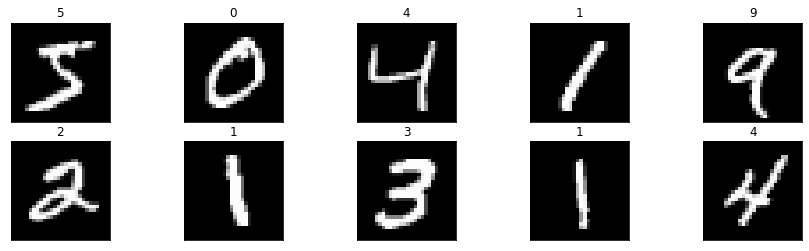

In [46]:
import matplotlib.pyplot as plt
    
images, digits = iter(train_loader).next()
images = images.numpy()

fig = plt.figure(figsize=(15, 4))
for i in np.arange(10):
    sub_plot = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    sub_plot.imshow(np.squeeze(images[i]), cmap='gray')
    sub_plot.set_title(str(digits[i].item()))

In [27]:
#images[1].shape

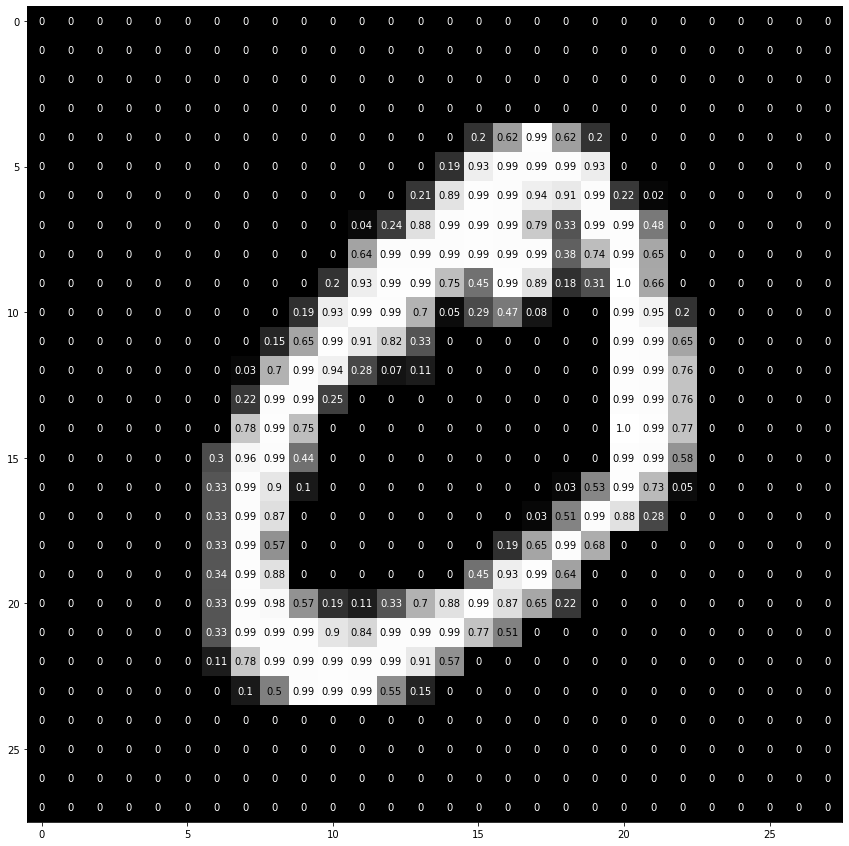

In [45]:
img = np.squeeze(images[1])

plt.figure(figsize = (15,15))
plt.imshow(img, cmap='gray')
width_px, height_px = img.shape
for x in range(width_px):
    for y in range(height_px):
        value = round(img[x][y],2) if img[x][y] !=0 else 0
        value = str(value)
        if img[x][y]<0.5:
          plt.annotate(value, xy=(y,x), horizontalalignment='center', verticalalignment='center', color='white')
        else:
          plt.annotate(value, xy=(y,x), horizontalalignment='center', verticalalignment='center', color='black')

In [47]:
import torch.nn as nn
import torch.nn.functional as function

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256) # width_px * height_px = 28*28 = 784
        self.fc2 = nn.Linear(256,64)
        self.fc3 = nn.Linear(64,10)
        self.drop = nn.Dropout(p=0.3)

    def forward(self, x):
        x = x.view(-1, 784)  # flatten image
        x = self.drop(function.relu(self.fc1(x))) 
        x = self.drop(function.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (drop): Dropout(p=0.3, inplace=False)
)


In [48]:
loss_func = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [54]:
train_loader.dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [56]:
n_iter = 10

model.train()

losses = []

for epoch in range(n_iter):
    train_loss = 0.0
    for images, digits in train_loader:
        model_output = model(images)
        loss = loss_func(model_output, digits)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()*images.size(0)
        
    train_loss = train_loss/len(train_loader.dataset)
    losses.append(train_loss)

    print(f'Epoch: {epoch+1} \t Training Loss : {train_loss:.5f}')

Epoch: 1 	 Training Loss : 0.05791
Epoch: 2 	 Training Loss : 0.05387
Epoch: 3 	 Training Loss : 0.05029
Epoch: 4 	 Training Loss : 0.04604
Epoch: 5 	 Training Loss : 0.04604
Epoch: 6 	 Training Loss : 0.04568
Epoch: 7 	 Training Loss : 0.04329
Epoch: 8 	 Training Loss : 0.04378
Epoch: 9 	 Training Loss : 0.03853
Epoch: 10 	 Training Loss : 0.03928


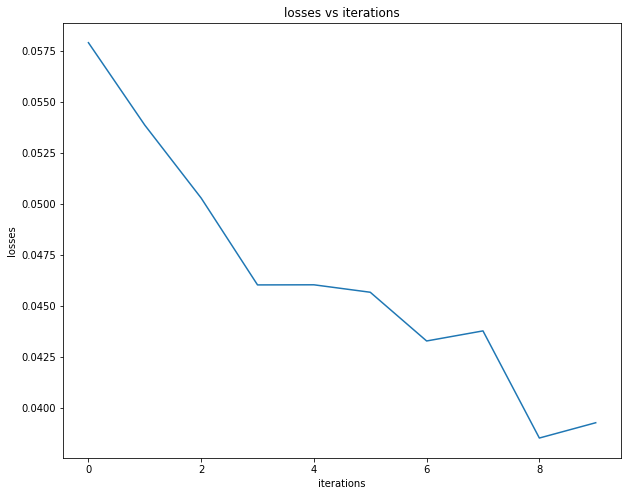

In [59]:
plt.figure(figsize = (10,8))
plt.plot(losses)
plt.title("losses vs iterations")
plt.xlabel('iterations')
plt.ylabel('losses')
plt.show()

In [86]:
# images, digits = iter(train_loader).next()
# _,x = torch.max(model(images),1)
# correct = x.eq(digits)
# correct.shape
# x = np.zeros(10)
# x

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
test_loss = 0.0
class_correct = np.zeros(10)
class_total = np.zeros(10)

model.eval()

for images, digits in test_loader:
    model_output = model(images)
    loss = loss_func(model_output, digits)
    test_loss += loss.item()*images.size(0)
 
    _, digits_pred = torch.max(model_output, 1)
    right_pred = digits_pred.eq(digits)

    for i in range(len(digits)):
        label = digits[i].item()
        class_correct[label] += right_pred[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            class_correct[i], class_total[i]))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.074025

Test Accuracy of     0: 99% (974/980)
Test Accuracy of     1: 99% (1128/1135)
Test Accuracy of     2: 97% (1011/1032)
Test Accuracy of     3: 96% (979/1010)
Test Accuracy of     4: 98% (964/982)
Test Accuracy of     5: 98% (878/892)
Test Accuracy of     6: 96% (928/958)
Test Accuracy of     7: 98% (1011/1028)
Test Accuracy of     8: 95% (932/974)
Test Accuracy of     9: 97% (986/1009)

Test Accuracy (Overall): 97% (9791/10000)


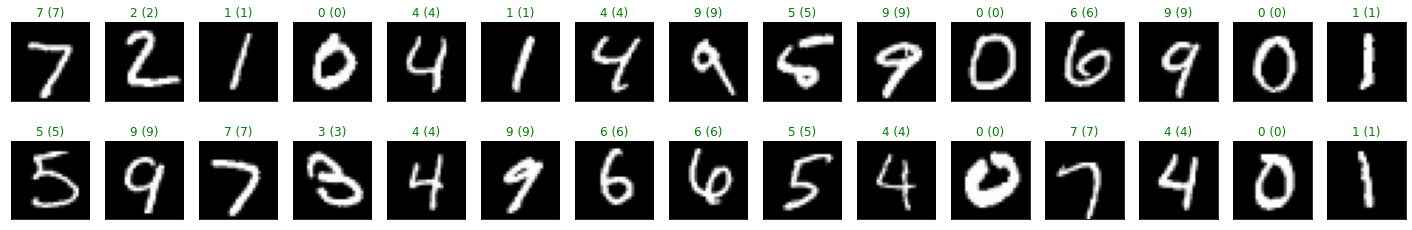

In [ ]:
images, labels = iter(test_loader).next()

output = model(images)
_, preds = torch.max(output, 1)
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(30):
    ax = fig.add_subplot(2, 15, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))